# Imports & Model Setup

In [3]:
import sys, os

root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)

import seaborn as sns
import pandas as pd
import numpy as np
from note_seq import midi_to_note_sequence, note_sequence_to_midi_file, note_sequence_to_pretty_midi
from heatmap import heatmap, corrplot
from src.evaluation import mgeval
from src.io import output, input, conversion
from src.generation import MusicVAEGenerator
from src.db import generations as db

C:\Users\Eric\miniconda3\envs\mpro\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


pygame 2.0.1 (SDL 2.0.14, Python 3.7.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
import music21
#music21.configure.run()
#music21.environment.set('musescoreDirectPNGPath', 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe')
#music21.environment.set('musicxmlPath', 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe')

In [5]:
vae = MusicVAEGenerator()

[GEN] Initializing Music VAE with checkpoint 'cat-mel_2bar_big'...
INFO:tensorflow:Building MusicVAE model with BidirectionalLstmEncoder, CategoricalLstmDecoder, and hparams:
{'max_seq_len': 32, 'z_size': 512, 'free_bits': 0, 'max_beta': 0.5, 'beta_rate': 0.99999, 'batch_size': 4, 'grad_clip': 1.0, 'clip_mode': 'global_norm', 'grad_norm_clip_to_zero': 10000, 'learning_rate': 0.001, 'decay_rate': 0.9999, 'min_learning_rate': 1e-05, 'conditional': True, 'dec_rnn_size': [2048, 2048, 2048], 'enc_rnn_size': [2048], 'dropout_keep_prob': 1.0, 'sampling_schedule': 'inverse_sigmoid', 'sampling_rate': 1000, 'use_cudnn': False, 'residual_encoder': False, 'residual_decoder': False, 'control_preprocessing_rnn_size': [256]}
INFO:tensorflow:
Encoder Cells (bidirectional):
  units: [2048]

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
INFO:tensorflow:
Decoder Cells:
  units: [2048, 2048, 2048]

Instructions for u

# Input Analysis

In [26]:
midi = input.loadMidiFile('../midi/examples/monophonic/twinkle1_4b.mid')
seq_input = midi_to_note_sequence(midi)

metrics1 = mgeval.analyze_sequence(seq_input)
metrics1

{'pitch_count': 6,
 'pitch_class_histogram': array([0.23534338, 0.        , 0.1239531 , 0.        , 0.12311558,
        0.11809045, 0.        , 0.2680067 , 0.        , 0.13149079,
        0.        , 0.        ]),
 'pitch_class_transition_matrix': array([[1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 'avg_pitch_interval': 1.3846153846153846,
 'pitch_rang

# Generate New Sequence

In [7]:
seq_gen_base = vae.generate(16, 0.6)
print(seq_gen_base['meta'])

{'gen_dur': 8.572552919387817, 'model': 'MusicVAE', 'checkpoint': 'cat-mel_2bar_big', 'temperature': 0.6}


# Gen_base Analysis

In [8]:
metrics2 = mgeval.analyze_sequence(seq_gen_base['sequence'])
distances = mgeval.calc_distances(metrics1, metrics2)

seq_gen_base['evaluation'] = {
    'metrics': metrics2,
    'distances_to_input': distances
}

metrics2

{'pitch_count': 5,
 'pitch_class_histogram': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.04862024, 0.55847569, 0.21287779, 0.        ,
        0.06570302, 0.11432326]),
 'pitch_class_transition_matrix': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 4., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]),
 'avg_pitch_interval': 0.8,
 'pitch_range': 5,
 'note_c

## Example Plot: Note Length Transition Matrix

Note Length Transitions - Input


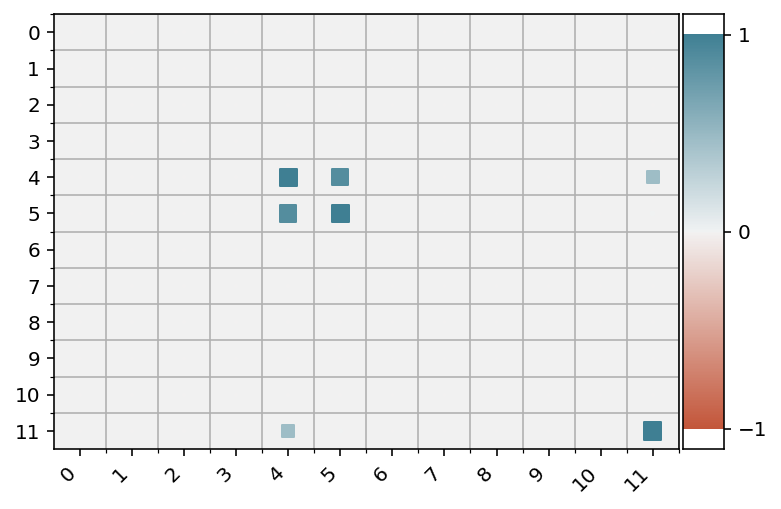

In [24]:
df1 = pd.DataFrame(metrics1['ioi_transition_matrix'])
corrplot(df1.corr(), size_scale=75)
print("Note Length Transitions - Input")

Note Length Transitions - Generation


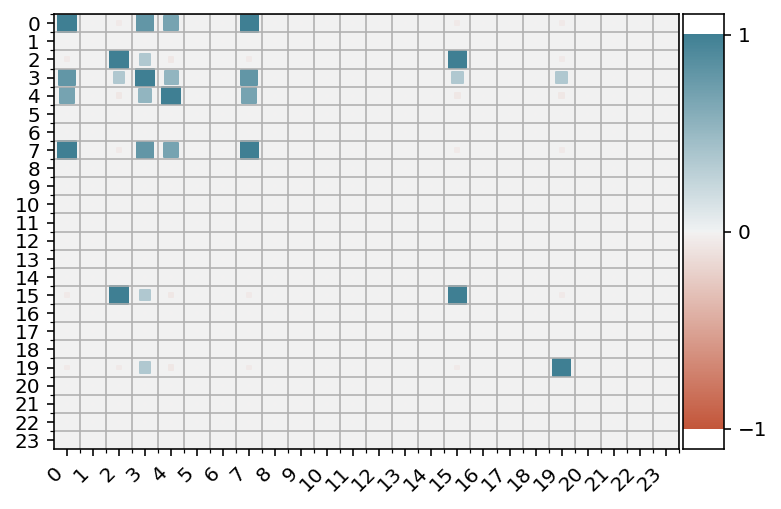

In [10]:
df2 = pd.DataFrame(metrics2['note_length_transition_matrix'])
corrplot(df2.corr(), size_scale=75)
print("Note Length Transitions - Generation")

## Piano Roll

In [11]:
output.pianoRollFromNoteSeq(seq_input)
output.pianoRollFromNoteSeq(seq_gen_base['sequence'])

Loading BokehJS ...

Loading BokehJS ...

## Similarity between input and gen_base

In [12]:
distances

{'pitch_count': 4.0,
 'pitch_class_histogram': 0.6630566954578923,
 'pitch_class_transition_matrix': 5.477225575051661,
 'avg_pitch_interval': 1.5888888888888888,
 'pitch_range': 5.0,
 'note_count': 8.0,
 'note_length_histogram': 0.7998233713962797,
 'note_length_transition_matrix': 14.0,
 'avg_ioi': 0.060185185185185175,
 'ioi_histogram': 0.7650716207198731,
 'ioi_transition_matrix': 10.770329614269007}

# Conversion to music21 stream

In [13]:
input_stream = conversion.note_seq_to_music21(seq_input)
input_stream.show('midi')

In [14]:
output_stream = conversion.note_seq_to_music21(seq_gen_base['sequence'])
output_stream.show('midi')

# Adaptation

In [15]:
allowedPitch = set()
for note in input_stream.parts[0].notes:
    allowedPitch.add(note.pitch.pitchClass)
print(allowedPitch)

def findClosest(lst, given_value):
    absolute_difference = lambda list_value : min(abs(list_value - given_value), abs(list_value+12 - given_value), abs(list_value-12 - given_value))
    return min(lst, key=absolute_difference)

{0, 2, 3, 4, 6, 7, 9, 10, 11}


In [16]:
print(input_stream.analyze('key'))
print(output_stream.analyze('key'))

e minor
E- major


In [17]:
for note in output_stream.parts[0].notes:
    old_pitch = note.pitch.pitchClass
    new_pitch = findClosest(allowedPitch, note.pitch.pitchClass)
    note.pitch.pitchClass += (new_pitch - old_pitch)
    note.pitch.octave += 2
    print(str(old_pitch) + ' => ' + str(new_pitch))

11 => 11
10 => 10
10 => 10
6 => 6
8 => 7
8 => 7
8 => 7
8 => 7
8 => 7
8 => 7
7 => 7


In [18]:
output_stream.show('midi')

In [19]:
mf = music21.midi.translate.streamToMidiFile(output_stream)
mf.open('../midi/tmp/adaption_cache.mid', 'wb')
mf.write()
mf.close()

In [20]:
midi_adapted = input.loadMidiFile('../midi/tmp/adaption_cache.mid')
seq_adapted = midi_to_note_sequence(midi_adapted)

In [21]:
metrics3 = mgeval.analyze_sequence(seq_adapted)
distances2 = mgeval.calc_distances(metrics1, metrics3)
seq_output = {}
seq_output['sequence'] = seq_adapted
seq_output['evaluation'] = {
    'metrics': metrics2,
    'distances_to_input': distances2
}

In [22]:
distances2

{'pitch_count': 5.0,
 'pitch_class_histogram': 0.7927405592751761,
 'pitch_class_transition_matrix': 6.164414002968976,
 'avg_pitch_interval': 1.7888888888888888,
 'pitch_range': 5.0,
 'note_count': 8.0,
 'note_length_histogram': 0.7998233713962797,
 'note_length_transition_matrix': 14.0,
 'avg_ioi': 0.060185185185185175,
 'ioi_histogram': 0.7808284072277645,
 'ioi_transition_matrix': 10.770329614269007}

In [23]:
id = db.store_generation_result(
    note_sequence_to_pretty_midi(seq_input),
    note_sequence_to_pretty_midi(seq_gen_base['sequence']),
    note_sequence_to_pretty_midi(seq_adapted),
    gen_dur = seq_gen_base['meta']['gen_dur'],
    gen_model = seq_gen_base['meta']['model'] + '_' + seq_gen_base['meta']['checkpoint'],
    gen_temperature = seq_gen_base['meta']['temperature'],
    adapt_dur = 0)
print(id)

TypeError: store_generation_result() got an unexpected keyword argument 'gen_dur'